In the waves.py script, we use the rectagular integration to create the wave. What if we use other integration methods?

In [8]:
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import xarray as xr
import scipy

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

Analytical Integral:
(0.14060250400979546, 7.896972151292775e-10)
Area
0.14060250400979565
Trapz with normal method:
-0.14051139751797542
Rect with new method:
0.14060250400979568
Trapz with new method:
-0.1405113941997157
1.0051616161906065
1.0031223006819079


C:\Users\jtgrasb\AppData\Local\Temp\ipykernel_13656\3925258144.py:18: RuntimeWarning: divide by zero encountered in scalar power
  spectrum_func = lambda f: a_param * f**(-5) * np.exp(-b_param * f**(-4))
C:\Users\jtgrasb\AppData\Local\Temp\ipykernel_13656\3925258144.py:18: RuntimeWarning: invalid value encountered in scalar multiply
  spectrum_func = lambda f: a_param * f**(-5) * np.exp(-b_param * f**(-4))


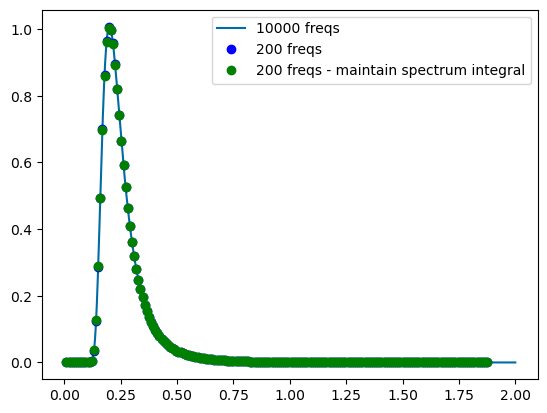

In [14]:
nfreq = 20
f1 = 1.875/nfreq

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

# irregular
Hs = 1.5
Tp = 5
direction = 0
nrealizations = 1
fp = 1/Tp
hs = Hs
b_param = (1.057*fp)**4
a_param = hs**2 / 4 * b_param

freqs = np.linspace(0,2,10000)

spectrum_func = lambda f: a_param * f**(-5) * np.exp(-b_param * f**(-4))

spec_vals = [spectrum_func(freq) for freq in freqs]
plt.figure()
plt.plot(freqs,spec_vals,label='10000 freqs')

freqs = np.linspace(f1,1.875,nfreq)

spec_vals = [spectrum_func(freq) for freq in freqs]
plt.plot(freqs,spec_vals,'bo',label=f'{nfreq} freqs')

print('Analytical Integral:')
print(scipy.integrate.quad(spectrum_func,freq[0]-f1/2,freq[-1]+f1/2))

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

area_sum = 0
#uncertain_sum = 0
amp = []
# calculate rectangular integral for each range
for f in freq:
    area = scipy.integrate.quad(spectrum_func,f-f1/2,f+f1/2)
    amp.append(area[0]/f1)
    area_sum = area_sum + area[0]
    #uncertain_sum = uncertain_sum + area[1]
print('Area')
print(area_sum)

plt.plot(freq,amp,'go',label=f'{nfreq} freqs - maintain spectrum integral')
plt.legend()
#plt.ylim([.037, .04])

print('Trapz with normal method:')
print(scipy.integrate.trapezoid(freqs,spec_vals))

area_sum = 0
for ind, f in enumerate(freq):
    if f == nfreq:
        area_sum = area_sum+amp[ind]*f1
    else:
        area_sum = area_sum+amp[ind]*f1

print('Rect with new method:')
print(area_sum)

print('Trapz with new method:')
print(scipy.integrate.trapezoid(freq,amp))

print(spec_vals[20])

print(amp[20])

In [15]:
# test my new method in terms of absorbable power

nfreqs = np.linspace(10,400,40)
Pmaxs = []

Pspec = []
Pareasum = []
Pmaxs_new = []

# irregular
Hs = 1.5
Tp = 5

for nfreq in nfreqs:
    # first, create waves normally and plot the absorbable power vs. number of frequencies
    f1 = 2/nfreq # Hz

    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

    fp = 1/Tp
    spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 1)

    in2m = 0.0254 # inch -> meter conversion factor
    draft = 0.5 # meters
    freeboard = 40. * in2m - draft
    hull_geom = wot.geom.WaveBot(r1=130./2 * in2m,
                                 r2=110./2 * in2m, 
                                 h1=22.679 * in2m,
                                 h2=17.321 * in2m,
                                 scale_factor=1,
                                 freeboard=freeboard)
    mesh = hull_geom.mesh(mesh_size_factor=0.5)
    #_ = hull_geom.plot_cross_section()
    buoy_props = {
        'CG': 0.242, # m
        'MOI': 7484., # kg-m^2
        'Resonance frequency': 0.35, # Hz
    }

    flywheel_props = {
        'MOI': 25,  # kg-m^2
        'Coulomb friction': 2.0,  # N-m
        'Viscous friction': 0.02,  # N-m/rad
        'Gear ratio': 3, # -
    }

    spring_props = {
        'Max torque': 750, # N-m
        'Max displacement': np.deg2rad(45.0), # rad
    }

    pnr_fb = cpy.FloatingBody.from_meshio(mesh, name="Pioneer")
    pnr_fb.add_rotation_dof(name='Pitch')
    pnr_fb.center_of_mass = np.array([0., 0., buoy_props['CG']])
    pnr_fb.rotation_center = pnr_fb.center_of_mass
    ndof = pnr_fb.nb_dofs
    #pnr_fb.show_matplotlib()

    pnr_fb.inertia_matrix = xr.DataArray([[buoy_props['MOI']]],
                                dims=['influenced_dof', 'radiating_dof'],
                                coords={'influenced_dof' : ['Pitch'],
                                'radiating_dof' : ['Pitch']},
                                name="inertia_matrix"
                                )

    rho = 1025. # kg/m^3
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
    bem_data = wot.run_bem(pnr_fb, freq, rho=rho)

    # calculate max power
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    ampSpect = waves_irregular.sel(realization=0).values
    Fe = np.squeeze(ampSpect)*np.squeeze(Fe.values)

    hydro_data = wot.add_linear_friction(bem_data)
    Zi = wot.hydrodynamic_impedance(hydro_data)

    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    Pmaxs.append(P_ub)
    
    hs = Hs
    b_param = (1.057*fp)**4
    a_param = hs**2 / 4 * b_param

    spectrum_func = lambda f: a_param * f**(-5) * np.exp(-b_param * f**(-4))
    
    Pspec.append(scipy.integrate.quad(spectrum_func,freq[0]-f1/2,freq[-1])[0])
    
    # waves with new method
    area_sum = 0
    amp = []
    ampSpect_new = []
    # calculate rectangular integral for each range
    for f in freq:
        if f == freq[-1]:
            area = scipy.integrate.quad(spectrum_func,f-f1/2,f)
        else:
            area = scipy.integrate.quad(spectrum_func,f-f1/2,f+f1/2)
        amp.append(area[0]/f1)
        ampSpect_new.append(np.sqrt(2*area[0]))
        area_sum = area_sum + area[0]
    
    print(area_sum)
        
    phases = wot.waves.random_phase([int(nfreq), 1,1],None)
    camplitude = ampSpect_new * np.exp(1j*np.squeeze(phases))
    
    Pareasum.append(area_sum)
    
    Fe = bem_data['Froude_Krylov_force'] + bem_data['diffraction_force']
    Fe = np.squeeze(camplitude)*np.squeeze(Fe.values)
    # Maximum Mechanical Power
    P_ub_vec = (1/8)*abs(Fe)**2/np.real(Zi.squeeze())
    P_ub = - sum(np.squeeze(P_ub_vec)).values
    Pmaxs_new.append(P_ub)

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


0.1406074473474773


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


0.14060744764557995


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


0.14060744764557997


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')
0.14060744764558006


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.24e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.24e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')
0.14060744764558


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')
0.14060744764557997


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.98e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')
0.14060744764558


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')
0.14060744764558014


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.27e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.27e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')
0.1406074476455799


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.24e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')
0.14060744764557997


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.86e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.62e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.12e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')
0.14060744764558017


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')
0.1406074476455802


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.63e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.24e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.74e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.16e-01.
This warning appears because the largest panel 

0.14060744764558


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.81e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')
0.14060744764557984


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.12e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.53e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.01e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.14e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel 

0.14060744764557973


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.41e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.27e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


0.1406074476455798


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.68e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.67e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel 

0.14060744764557992


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.93e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.36e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.76e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.78e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.37e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.27e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel 

0.14060744764557992


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.02e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.52e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.93e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.47e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel 

0.14060744764557992


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.96e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.04e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel 

0.1406074476455802


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.00e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.44e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.98e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.37e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.26e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.24e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.00e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.44e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.98e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.37e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.26e-01.
This warning appears because the largest panel 

0.14060744764557992


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.64e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.20e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.45e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.29e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.99e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel 

0.14060744764557961


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.69e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.32e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.72e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.27e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.17e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.01e-01.
This warning appears because the largest panel 

0.14060744764557975


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.86e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.51e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.77e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.86e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.46e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel 

0.14060744764558017


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.00e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.70e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.95e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.10e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.41e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel 

0.14060744764558025


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.04e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.88e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.12e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.86e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.72e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.87e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.55e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


0.14060744764557984


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.88e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.33e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.20e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.34e-01.
This warning appears because the largest panel 

0.1406074476455801


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.13e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.56e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.44e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.31e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


0.1406074476455795


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.29e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.72e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.22e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.31e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.30e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.25e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.00e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.70e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.74e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.31e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.25e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


0.1406074476455805


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.44e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.88e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.71e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.24e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.45e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.52e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.76e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.85e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel 

0.14060744764558003


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.03e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.41e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.38e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.95e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.10e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.41e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.15e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.43e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


0.1406074476455801


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.65e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.34e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.49e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.87e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel 

0.1406074476455795


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.10e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.26e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.34e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.54e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.38e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.24e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.55e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.83e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.75e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.15e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel 

0.1406074476455803


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.09e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.40e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.24e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.67e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.88e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.27e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.25e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.35e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.33e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.32e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.09e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.08e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.07e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.06e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.05e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.60e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.34e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.19e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.05e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.22e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.49e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel 

0.1406074476455794


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.12e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.04e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.53e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.64e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.06e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.28e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.27e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.26e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.24e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.03e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.89e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.21e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.17e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


0.14060744764557967


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.16e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.66e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.50e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.77e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.38e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.48e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.32e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.66e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.40e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel 

0.14060744764557975


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.36e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.20e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.73e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.58e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.67e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.34e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.59e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.72e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.63e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.86e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.78e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.74e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.71e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.97e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.36e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.95e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.


0.14060744764557984


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.31e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.09e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.70e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.79e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.64e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.61e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.54e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.88e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.85e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.28e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.12e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.11e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.39e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.31e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.24e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.91e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.79e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.84e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.80e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.75e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.66e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.79e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.75e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.05e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.02e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.45e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.97e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.92e-01.
This warning appears because the largest panel 

0.14060744764558022


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.37e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.13e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.58e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.42e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.78e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.52e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.47e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.55e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.51e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.42e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.69e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.62e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.59e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.93e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.43e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.41e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.36e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.34e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.92e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.41e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.89e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.81e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.65e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.58e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.27e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.92e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.02e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.98e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.23e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.71e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.66e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.61e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.16e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.11e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.09e-01.
This warning appears because the largest panel 

0.14060744764557953


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.43e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.42e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.40e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.39e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.38e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.18e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.17e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.16e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.15e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.14e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.83e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.76e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.68e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.60e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.53e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.26e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.20e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.08e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.13e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.08e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.03e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.94e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.18e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.14e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.10e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.06e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.02e-01.
This warning appears because the largest panel 

('Pitch', 'Pitch')


The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.77e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.73e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.70e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.67e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.63e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.07e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.04e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.01e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.96e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.49e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.46e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.42e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.39e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.00e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.98e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.96e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.94e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=3.92e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.23e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.22e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.21e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.20e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.19e+00.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.02e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=1.01e+00.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.99e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=9.91e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.63e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.57e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.44e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=8.38e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.38e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.27e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.23e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=7.18e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.37e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.33e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.29e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.25e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=6.21e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.56e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.53e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.50e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.47e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=5.43e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.90e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.87e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.85e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.82e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.79e-01.
This warning appears because the largest panel 

The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.35e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.32e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.30e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.28e-01.
This warning appears because the largest panel of this mesh has radius 1.79e-01 > λ/8.
The resolution of the mesh 'Pioneer' of the body 'Pioneer_immersed' might be insufficient for the wavelength λ=4.26e-01.
This warning appears because the largest panel 

0.1406074476455802


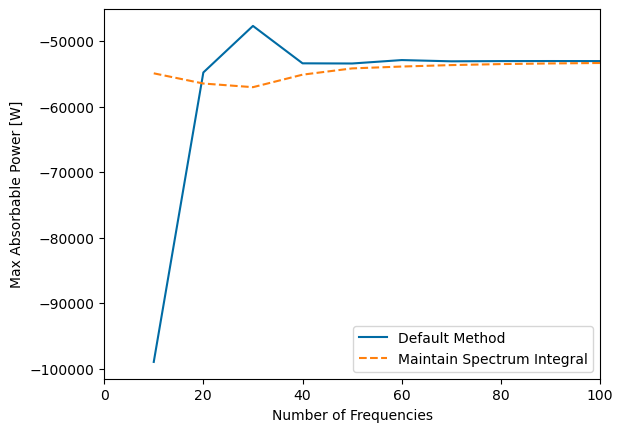

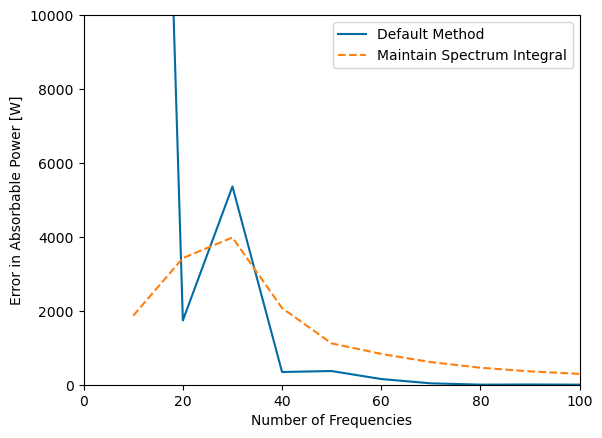

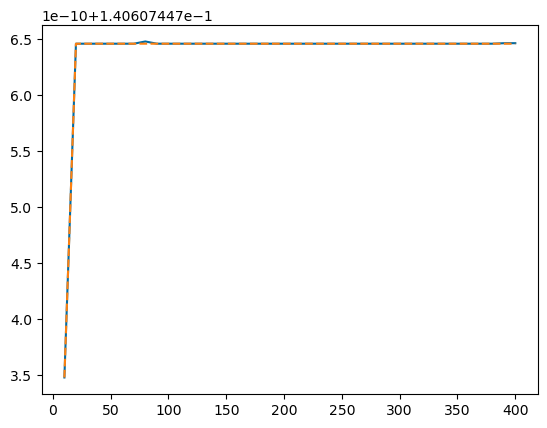

In [23]:
plt.figure()
plt.plot(nfreqs,Pmaxs,label='Default Method')
plt.plot(nfreqs,Pmaxs_new,'--',label='Maintain Spectrum Integral')
#plt.ylim([-54000, -52800])
plt.xlim([0,100])
plt.ylabel('Max Absorbable Power [W]')
plt.xlabel('Number of Frequencies')
plt.legend()

error_default = abs(Pmaxs - Pmaxs[-1])
error_new = abs(Pmaxs_new - Pmaxs[-1])

plt.figure()
plt.plot(nfreqs,error_default,label='Default Method')
plt.plot(nfreqs,error_new,'--',label='Maintain Spectrum Integral')
plt.ylabel('Error in Absorbable Power [W]')
plt.xlabel('Number of Frequencies')
plt.ylim([0, 10000])
plt.xlim([0, 100])
plt.legend()

plt.figure()
plt.plot(nfreqs,Pspec)
plt.plot(nfreqs,Pareasum,'--')

[0.004 0.008 0.012 0.016 0.02  0.024 0.028 0.032 0.036 0.04  0.044 0.048
 0.052 0.056 0.06  0.064 0.068 0.072 0.076 0.08  0.084 0.088 0.092 0.096
 0.1   0.104 0.108 0.112 0.116 0.12  0.124 0.128 0.132 0.136 0.14  0.144
 0.148 0.152 0.156 0.16  0.164 0.168 0.172 0.176 0.18  0.184 0.188 0.192
 0.196 0.2   0.204 0.208 0.212 0.216 0.22  0.224 0.228 0.232 0.236 0.24
 0.244 0.248 0.252 0.256 0.26  0.264 0.268 0.272 0.276 0.28  0.284 0.288
 0.292 0.296 0.3   0.304 0.308 0.312 0.316 0.32  0.324 0.328 0.332 0.336
 0.34  0.344 0.348 0.352 0.356 0.36  0.364 0.368 0.372 0.376 0.38  0.384
 0.388 0.392 0.396 0.4   0.404 0.408 0.412 0.416 0.42  0.424 0.428 0.432
 0.436 0.44  0.444 0.448 0.452 0.456 0.46  0.464 0.468 0.472 0.476 0.48
 0.484 0.488 0.492 0.496 0.5   0.504 0.508 0.512 0.516 0.52  0.524 0.528
 0.532 0.536 0.54  0.544 0.548 0.552 0.556 0.56  0.564 0.568 0.572 0.576
 0.58  0.584 0.588 0.592 0.596 0.6   0.604 0.608 0.612 0.616 0.62  0.624
 0.628 0.632 0.636 0.64 ]
Area:
0.004330339092552632


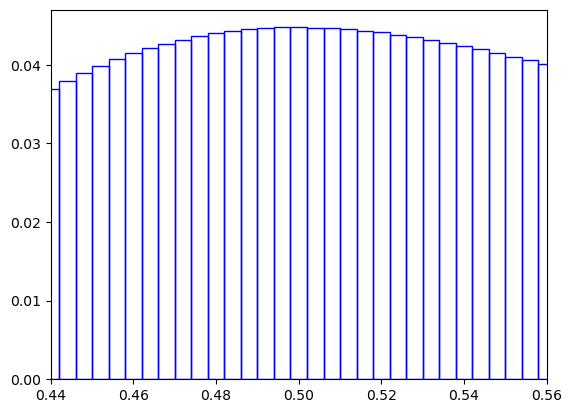

In [5]:
# irregular wave creation
# create irregular wave 

f1 = .004
nfreq = 160

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

# irregular
Hs = .5
Tp = 2
direction = 0
nrealizations = 1

fp = 1/Tp

hs = Hs
b_param = (1.057*fp)**4
a_param = hs**2 / 4 * b_param
    
spectrum = a_param * freq**(-5) * np.exp(-b_param * freq**(-4))
# if scalar, return scalar
spectrum = spectrum.item() if (spectrum.size == 1) else spectrum

#print(spectrum)

print(freq)

plt.figure()
plt.bar(freq,spectrum, width=f1, edgecolor='blue', color='none')
plt.xlim([0.44,0.56])

area = 0
for ind, f in enumerate(freq):
    if .45 < f < .55:
        area = area + spectrum[ind]*f1

print('Area:')
print(area)





In [46]:
# create irregular wave 

f1 = 1.875/20
nfreq = 20

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

# irregular
Hs = 1.5
Tp = 5 
direction = 0
nrealizations = 1

fp = 1/Tp

spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "Pierson-Moskowitz")

f1, nfreq = wot.waves.frequency_parameters(efth.freq.values, False)
df = f1

values = efth.values
values[values<0] = np.nan
amplitudes = np.sqrt(2 * values * df)
amplitudes = np.expand_dims(amplitudes,axis=2)

attr = {
    'Wave type': 'Long-crested irregular',
    'Direction (degrees)': direction,
}

waves_irregular = wot.waves.elevation_fd(f1, nfreq, direction, nrealizations, amplitudes, None, attr)

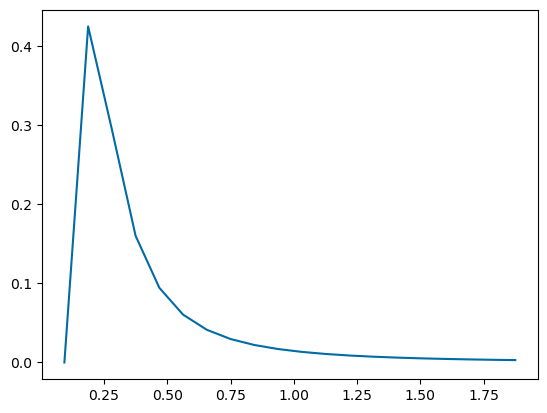

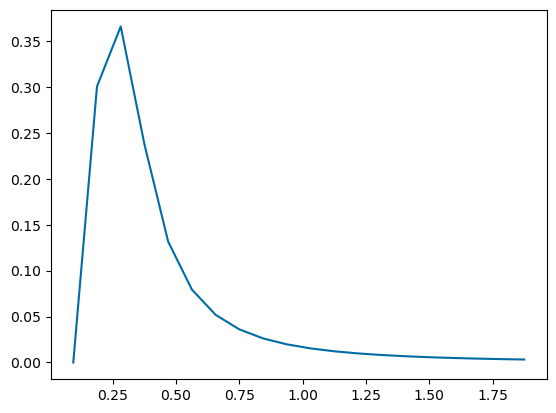

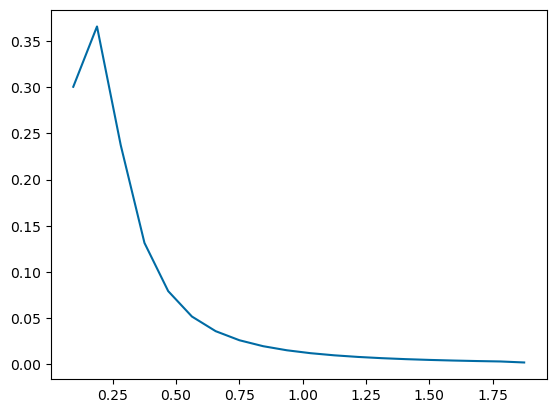

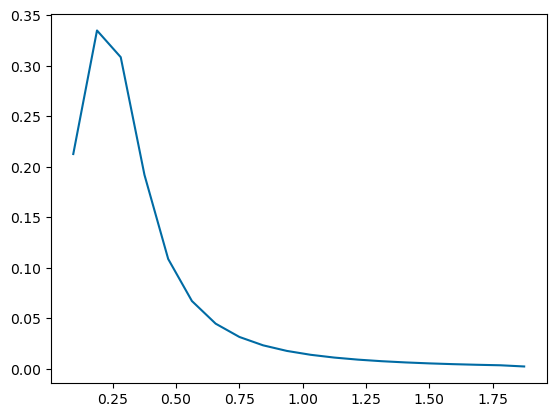

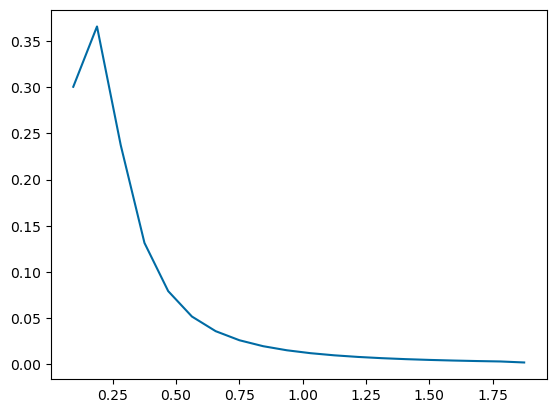

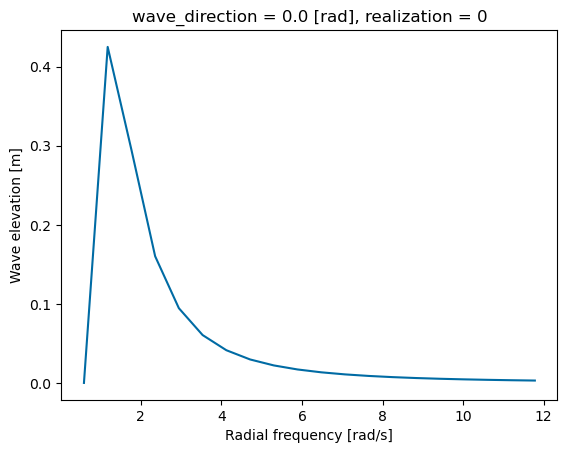

In [47]:
# integrate S (efth)

S = values

wave_amp = np.zeros(len(values))
df = f1

# instead of 2*values*df, we should do trapezoid:
# values_i*df + values_i-1*df
for ind, val in enumerate(S):
    if ind == 0:
        wave_amp[ind] = np.sqrt(val*2*df)
    else:
        wave_amp[ind] = np.sqrt(val*2*df)# + S[ind-1]*df)
        
plt.figure()
plt.plot(freq, wave_amp)

# trapezoidal lower
for ind, val in enumerate(S):
    if ind == 0:
        wave_amp[ind] = np.sqrt(0*df + val*df)
    else:
        wave_amp[ind] = np.sqrt(val*df + S[ind-1]*df)
        
plt.figure()
plt.plot(freq, wave_amp)

# trapezoidal upper
for ind, val in enumerate(S):
    if ind == len(S)-1:
        wave_amp[ind] = np.sqrt(0*df + val*df)
    else:
        wave_amp[ind] = np.sqrt(val*df + S[ind+1]*df)
        
plt.figure()
plt.plot(freq, wave_amp)

# trapezoidal middle
for ind, val in enumerate(S):
    if ind == 0:
        val1 = 0
        val2 = (S[ind]+S[ind+1])/2
    elif ind == len(S)-1:
        val2 = 0
        val1 = (S[ind]+S[ind-1])/2
    else:
        val1 = (S[ind]+S[ind-1])/2
        val2 = (S[ind]+S[ind+1])/2
    wave_amp[ind] = np.sqrt(2*((val1+val2)/2)*df)

plt.figure()
plt.plot(freq, wave_amp)

# simpson
for ind, val in enumerate(S):
    if ind == len(S)-1:
        wave_amp[ind] = np.sqrt(0*df + val*df)
    else:
        wave_amp[ind] = np.sqrt(val*df + S[ind+1]*df)
        
plt.figure()
plt.plot(freq, wave_amp)

fig, ax = plt.subplots()
plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
    ax=ax, color='C0')

rect
0.07020742815795986
trapz
0.07020742815795986
simpson
0.0703868156421119
<xarray.DataArray 'wave_elev' ()>
array(1.87315139)
Coordinates:
    wave_direction  float64 0.0
    realization     int32 0


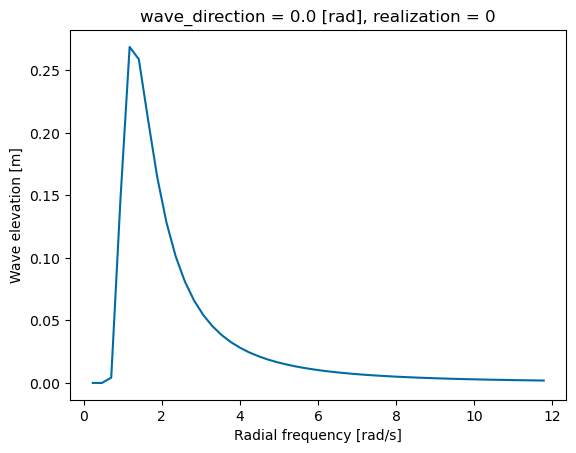

In [23]:
fig, ax = plt.subplots()
plt1 = np.abs(waves_irregular.sel(realization=0)).plot(
    ax=ax, color='C0')

wave_amp = np.squeeze(abs(waves_irregular.sel(realization=0)))

df = f1
wave_int = 0

for ind, amp in enumerate(wave_amp):
    if ind == 0 or ind == 49:
        wave_int = wave_int+amp*df/2
    else:
        wave_int = wave_int+amp*df

print('rect')
print(wave_int.values)

wave_int = scipy.integrate.trapezoid(wave_amp,freq)
print('trapz')
print(wave_int)

wave_int = scipy.integrate.simpson(wave_amp,freq)
print('simpson')
print(wave_int)

print(sum(wave_amp))

In [ ]:
# create WEC and run BEM

nfreqs = np.linspace(20,100,9)
fend = 1.875

for nfreq in nfreqs:
    
#    if nfreq >= 30:
#        scale_x_wec=1e1
#        scale_x_opt=1e-2
#        scale_obj=1e-2
    
    f1 = fend/nfreq
    freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

    efth = wot.waves.omnidirectional_spectrum(f1, int(nfreq), spectrum, "Pierson-Moskowitz")
    waves_irregular = wot.waves.long_crested_wave(efth, nrealizations = 1)

    

Text(0, 0.5, 'Amplitude')

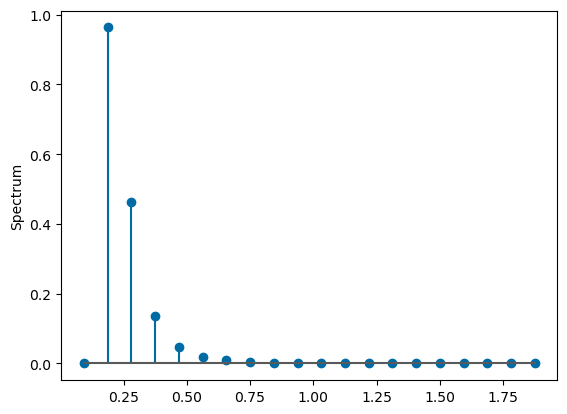

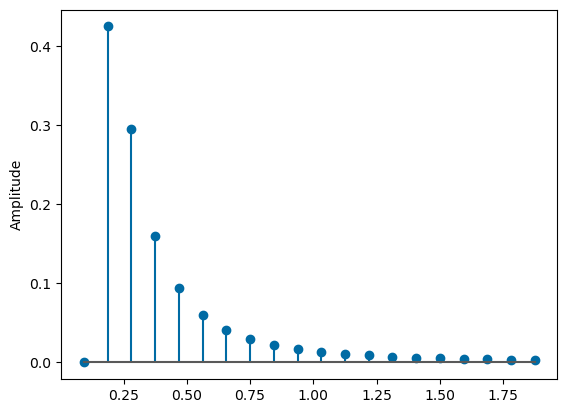

In [53]:
plt.figure()
plt.stem(freq,S)
plt.ylabel('Spectrum')

for ind, val in enumerate(S):
    if ind == 0:
        wave_amp[ind] = np.sqrt(val*2*df)
    else:
        wave_amp[ind] = np.sqrt(val*2*df)# + S[ind-1]*df)
        
plt.figure()
plt.stem(freq, wave_amp)
plt.ylabel('Amplitude')